 # A simple test of using `optuna` for hyperparameter optimization

In [1]:
import os
import time
from types import SimpleNamespace
from functools import partial

import pydove as dv
from tqdm.notebook import tqdm

import torch
from cpcn import LinearBioPCN, load_mnist, Trainer

import optuna
from optuna.trial import TrialState

import pickle

 ## Defining the optimization

In [2]:
def optuna_reporter(trial: optuna.trial.Trial, ns: SimpleNamespace):
    trial.report(ns.val_loss, ns.epoch)

    # early pruning
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()


def create_biopcn(trial):
    dims = [28 * 28, 5, 10]

    rho = 0.015

    z_lr = trial.suggest_float("z_lr", 0.01, 0.2, log=True)
    # z_lr = 0.1

    # set parameters to match a simple PCN network
    g_a = 0.5 * torch.ones(len(dims) - 2)
    g_a[-1] *= 2

    g_b = 0.5 * torch.ones(len(dims) - 2)
    g_b[0] *= 2

    net = LinearBioPCN(
        dims,
        z_lr=z_lr,
        z_it=50,
        g_a=g_a,
        g_b=g_b,
        c_m=0,
        l_s=g_b,
        rho=rho,
        bias_a=False,
        bias_b=False,
    )

    return net


def objective(
    trial: optuna.trial.Trial,
    n_batches: int,
    dataset: dict,
    device: torch.device,
    seed: int,
    n_rep: int,
) -> float:
    scores = torch.zeros(n_rep)
    for i in tqdm(range(n_rep)):
        torch.manual_seed(seed + i)
        net = create_biopcn(trial).to(device)

        optimizer_class = torch.optim.SGD
        lr = trial.suggest_float("lr", 5e-4, 0.05, log=True)

        trainer = Trainer(net, dataset["train"], dataset["validation"])
        trainer.set_optimizer(optimizer_class, lr=lr)

        lr_power = 1.0
        lr_rate = trial.suggest_float("lr_rate", 1e-5, 0.2, log=True)
        trainer.add_scheduler(
            partial(
                torch.optim.lr_scheduler.LambdaLR,
                lr_lambda=lambda batch: 1 / (1 + lr_rate * batch ** lr_power),
            ),
            every=1,
        )

        Q_lrf = trial.suggest_float("Q_lrf", 0.1, 20, log=True)
        trainer.set_lr_factor("Q", Q_lrf)

        trainer.peek_validation(count=10)

        # trainer.add_epoch_observer(lambda ns: optuna_reporter(trial, ns))
        results = trainer.run(n_batches=n_batches)
        scores[i] = results.validation["pc_loss"][-1]

    score = torch.quantile(scores, 0.90).item()
    return score

In [3]:
# minimizing PC loss
t0 = time.time()

device = torch.device("cpu")

n_batches = 500
seed = 1927
n_rep = 5

dataset = load_mnist(n_validation=500, batch_size=100)

sampler = optuna.samplers.TPESampler(seed=seed)
study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(
    lambda trial: objective(trial, n_batches, dataset, device, seed, n_rep),
    n_trials=25,
    timeout=15000,
    show_progress_bar=True,
)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

t1 = time.time()

[I 2022-05-06 15:25:49,046] A new study created in memory with name: no-name-549721c2-0cf9-44aa-a674-e9546d2fa588
/mnt/home/ttesileanu/miniconda3/envs/cpcn/lib/python3.9/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[I 2022-05-06 15:26:42,176] Trial 0 finished with value: 0.6084989905357361 and parameters: {'z_lr': 0.038522002211863124, 'lr': 0.006787027494852526, 'lr_rate': 0.006877190717936717, 'Q_lrf': 0.7760034678738864}. Best is trial 0 with value: 0.6084989905357361.


  0%|          | 0/5 [00:00<?, ?it/s]

[W 2022-05-06 15:27:29,684] Trial 1 failed, because the objective function returned nan.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2022-05-06 15:28:16,348] Trial 2 finished with value: 0.7891234159469604 and parameters: {'z_lr': 0.01325310443360926, 'lr': 0.008260745183109512, 'lr_rate': 0.0001154257044083364, 'Q_lrf': 0.42135169450516174}. Best is trial 0 with value: 0.6084989905357361.


  0%|          | 0/5 [00:00<?, ?it/s]

[W 2022-05-06 15:29:03,362] Trial 3 failed, because the objective function returned nan.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2022-05-06 15:29:50,243] Trial 4 finished with value: 2.2908244132995605 and parameters: {'z_lr': 0.03049698674558967, 'lr': 0.0006754213311238003, 'lr_rate': 8.146078329472453e-05, 'Q_lrf': 0.9124755124242356}. Best is trial 0 with value: 0.6084989905357361.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2022-05-06 15:30:37,833] Trial 5 finished with value: 0.3702264428138733 and parameters: {'z_lr': 0.13456989566363015, 'lr': 0.002929420137785704, 'lr_rate': 0.0001866907164621902, 'Q_lrf': 3.5126516651181805}. Best is trial 5 with value: 0.3702264428138733.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2022-05-06 15:31:25,261] Trial 6 finished with value: 3.9356799125671387 and parameters: {'z_lr': 0.03665888431434577, 'lr': 0.004645908620518579, 'lr_rate': 0.000151803277662764, 'Q_lrf': 0.16541746050010894}. Best is trial 5 with value: 0.3702264428138733.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2022-05-06 15:32:12,523] Trial 7 finished with value: 0.8982683420181274 and parameters: {'z_lr': 0.10117005889429422, 'lr': 0.0006471057980224879, 'lr_rate': 0.004618014776221226, 'Q_lrf': 5.330808717723938}. Best is trial 5 with value: 0.3702264428138733.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2022-05-06 15:33:00,890] Trial 8 finished with value: 18.97935676574707 and parameters: {'z_lr': 0.13607459530153945, 'lr': 0.001986274647451033, 'lr_rate': 0.009789658043153923, 'Q_lrf': 0.2264220075612389}. Best is trial 5 with value: 0.3702264428138733.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2022-05-06 15:33:46,835] Trial 9 finished with value: 0.7105798721313477 and parameters: {'z_lr': 0.018223155573181923, 'lr': 0.004410047218501098, 'lr_rate': 0.004555134038546109, 'Q_lrf': 0.7766072419353063}. Best is trial 5 with value: 0.3702264428138733.


  0%|          | 0/5 [00:00<?, ?it/s]

[W 2022-05-06 15:34:32,611] Trial 10 failed, because the objective function returned nan.


  0%|          | 0/5 [00:00<?, ?it/s]

[W 2022-05-06 15:35:18,508] Trial 11 failed, because the objective function returned nan.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2022-05-06 15:36:03,903] Trial 12 finished with value: 0.37180426716804504 and parameters: {'z_lr': 0.05048039332158416, 'lr': 0.003116003634180505, 'lr_rate': 5.4623365617103015e-05, 'Q_lrf': 2.2699129796242987}. Best is trial 5 with value: 0.3702264428138733.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2022-05-06 15:36:49,456] Trial 13 finished with value: 0.7712779641151428 and parameters: {'z_lr': 0.02487099787014018, 'lr': 0.0009023598338073872, 'lr_rate': 0.0017385220232214035, 'Q_lrf': 4.130845309066667}. Best is trial 5 with value: 0.3702264428138733.


  0%|          | 0/5 [00:00<?, ?it/s]

[W 2022-05-06 15:37:35,394] Trial 14 failed, because the objective function returned nan.


  0%|          | 0/5 [00:00<?, ?it/s]

[W 2022-05-06 15:38:20,683] Trial 15 failed, because the objective function returned nan.


  0%|          | 0/5 [00:00<?, ?it/s]

[W 2022-05-06 15:39:06,338] Trial 16 failed, because the objective function returned nan.


  0%|          | 0/5 [00:00<?, ?it/s]

[W 2022-05-06 15:39:52,184] Trial 17 failed, because the objective function returned nan.


  0%|          | 0/5 [00:00<?, ?it/s]

[W 2022-05-06 15:40:38,851] Trial 18 failed, because the objective function returned nan.


  0%|          | 0/5 [00:00<?, ?it/s]

[W 2022-05-06 15:41:25,358] Trial 19 failed, because the objective function returned nan.


  0%|          | 0/5 [00:00<?, ?it/s]

[W 2022-05-06 15:42:11,849] Trial 20 failed, because the objective function returned nan.


  0%|          | 0/5 [00:00<?, ?it/s]

[W 2022-05-06 15:42:58,400] Trial 21 failed, because the objective function returned nan.


  0%|          | 0/5 [00:00<?, ?it/s]

[W 2022-05-06 15:43:44,766] Trial 22 failed, because the objective function returned nan.


  0%|          | 0/5 [00:00<?, ?it/s]

[W 2022-05-06 15:44:31,136] Trial 23 failed, because the objective function returned nan.


  0%|          | 0/5 [00:00<?, ?it/s]

[W 2022-05-06 15:45:17,218] Trial 24 failed, because the objective function returned nan.


In [4]:
print(
    f"{len(study.trials)} trials in {t1 - t0:.1f} seconds: "
    f"{len(complete_trials)} complete, {len(pruned_trials)} pruned."
)

trial = study.best_trial
print(f"best pc_loss: {trial.value}, for params:")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

25 trials in 1168.3 seconds: 10 complete, 0 pruned.
best pc_loss: 0.3702264428138733, for params:
    z_lr: 0.13456989566363015
    lr: 0.002929420137785704
    lr_rate: 0.0001866907164621902
    Q_lrf: 3.5126516651181805


<ipython-input-5-83c13c1a414d>:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<AxesSubplot:title={'center':'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

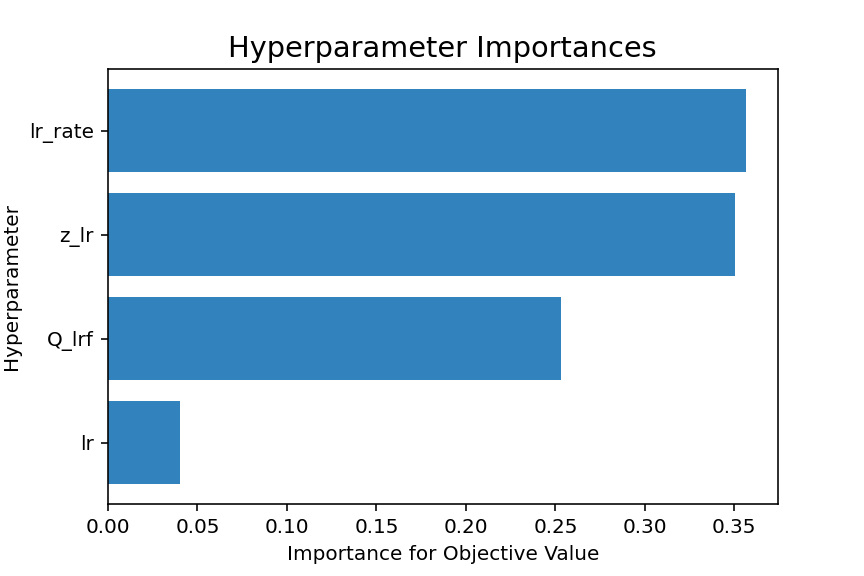

In [5]:
optuna.visualization.matplotlib.plot_param_importances(study)

In [6]:
with open(os.path.join("save", "hyperopt_biopcn.pkl"), "wb") as f:
    pickle.dump(study, f)